# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [36]:
from utils import get_dataset
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from PIL import Image
from os import listdir
from os.path import isfile, join

In [37]:
dataset = get_dataset("/app/project/data/test/segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/app/project/data/test/segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/app/project/data/test/segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [143]:
%matplotlib inline
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    axs_x = 3
    axs_y = 3
    assert(axs_x * axs_y >= len(list(batch)))
    
    colors = ['g', 'r', 'b', 'y', 'magenta', 'cyan']
    
    f, ax = plt.subplots(axs_y, axs_x, figsize=(10, 10))
    index = 0
    for element in batch:
        x_pos = index % axs_x
        y_pos = int(index / axs_x)
        image = element["image"]
        bboxes = element["groundtruth_boxes"]
        classes = element["groundtruth_classes"]
        
        ax[y_pos, x_pos].imshow(image.numpy())
        for (bb, classification) in zip(bboxes, classes):
            y1, x1, y2, x2 = bb.numpy() * 640
            rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor=colors[classification])
            ax[y_pos, x_pos].add_patch(rec)
        index += 1
        
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

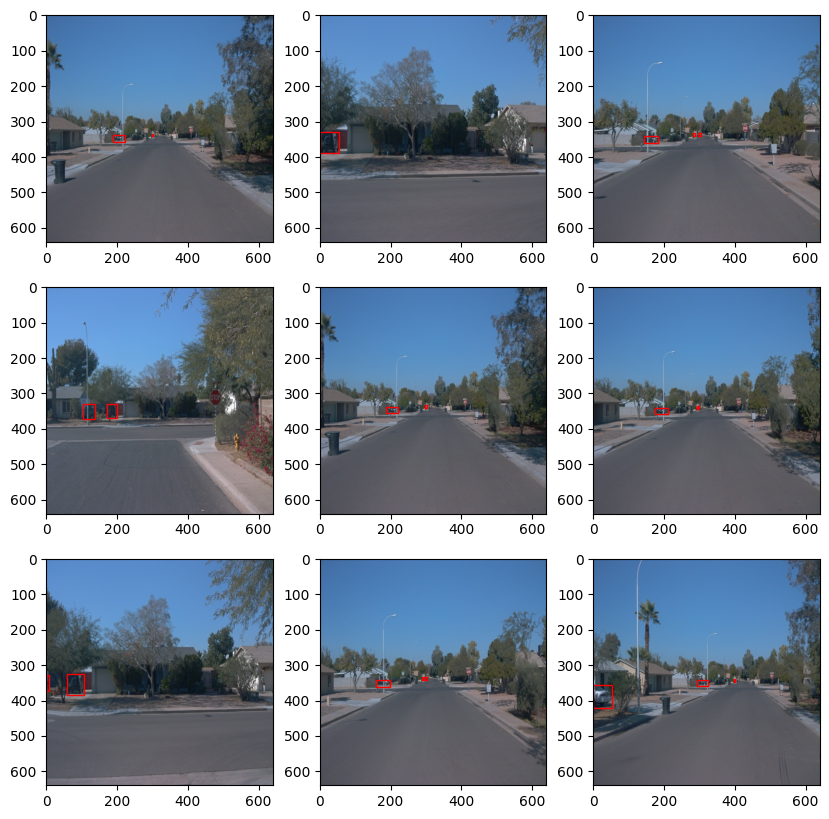

In [150]:
dataset.shuffle(42, reshuffle_each_iteration=True)
batch = dataset.take(9)
display_instances(batch)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

INFO:tensorflow:Reading unweighted datasets: ['/app/project/data/val/segment-12174529769287588121_3848_440_3868_440_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/app/project/data/val/segment-12174529769287588121_3848_440_3868_440_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1

/app/project/data/val/segment-12174529769287588121_3848_440_3868_440_with_camera_labels.tfrecord

INFO:tensorflow:Reading unweighted datasets: ['/app/project/data/val/segment-11967272535264406807_580_000_600_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/app/project/data/val/segment-11967272535264406807_580_000_600_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1

/app/project/data/val/segment-11967272535264406807_580_000_600_000_with_camera_labels.tfrecord

INFO:tensorflow:Reading unweighted datasets: ['/app/project/data/val/segment-12161824480686739258_1813_380_1

/tmp/ipykernel_10220/307302297.py:64: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig('/app/project/class_ditribution_val.png')


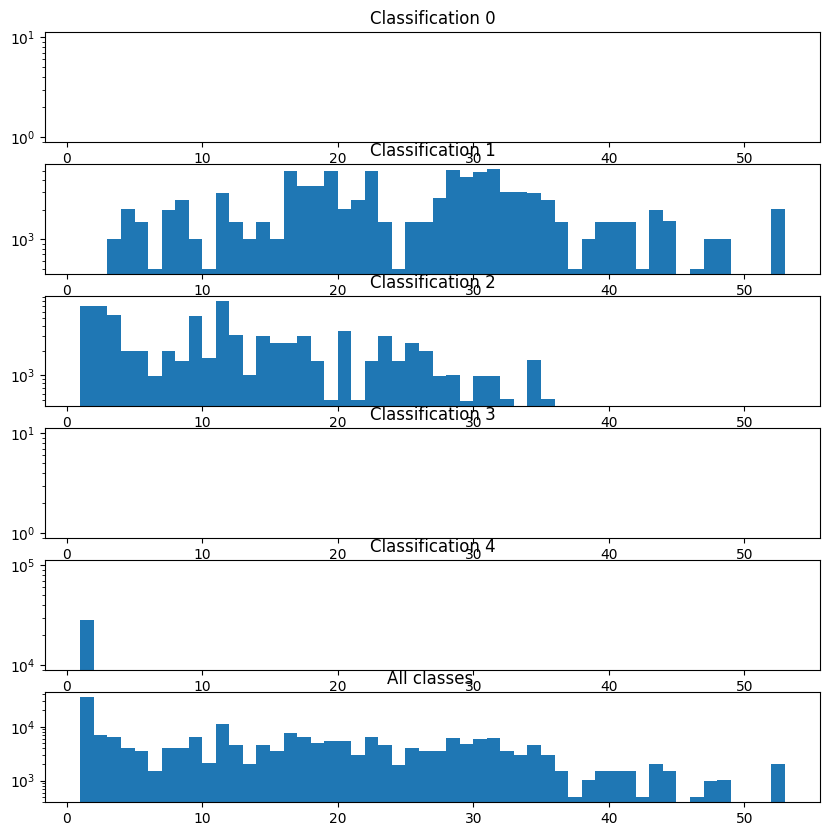

In [101]:
%matplotlib inline
base_path = "/app/project/data/val/"
num_classes = 5

def get_files(base_path):
    files = [join(base_path, f) for f in listdir(base_path) if isfile(join(base_path, f))]
    return files

class Stats:
    def __init__(self):
        self.classifications_per_frame = []
        self.classifications = np.full(shape=num_classes, fill_value=0, dtype=np.int)

def get_statistics(path):
    dataset = get_dataset(path)
    stats = Stats()
    index = 0
    print()
    print(path)
    print()
    for element in dataset:
        if index >= 10000:
            break
        classes = element["groundtruth_classes"].numpy()
        classifications_in_frame = np.full(shape=num_classes, fill_value=0, dtype=np.int)
        for classification in classes:
            assert(classification < num_classes)
            classifications_in_frame[classification] += 1
        stats.classifications_per_frame.append(classifications_in_frame)
        stats.classifications += classifications_in_frame
        index += 1
    return stats

    
files = get_files(base_path)
stats_all_files = []

# Get statistics
for file in files:
    stats_all_files.append(get_statistics(file))
    
# Process and plot
found_per_classification = [[], [], [], [], []]
for stats in stats_all_files:
    for classifications_in_frame in stats.classifications_per_frame:
        index = 0
        for num_classifications in classifications_in_frame:
            found_per_classification[index].append(num_classifications)
            index += 1

f, ax = plt.subplots(num_classes + 1, 1, figsize=(10, 10))
        
total_classifications = []
min = 1
max = np.max(found_per_classification)
for i in range(num_classes):
    ax[i].hist(found_per_classification[i], bins=max-min, range=(min, max), align='mid', log=True)
    ax[i].set_title('Classification ' + str(i))
    total_classifications = total_classifications + found_per_classification[i]


ax[num_classes].hist(total_classifications, bins=max-min, range=(min, max), align='mid', log=True)
ax[num_classes].set_title('All classes ')
plt.savefig('/app/project/class_ditribution_val.png')
plt.show()
